# **Breast Cancer - Comparative Analysis (Explainability with GradCAM) - NasNetLarge**

Dataset (Train and Validation) link: https://web.inf.ufpr.br/vri/databases/breast-cancer-histopathological-database-breakhis/

Annotated Dataset (Test) link: https://figshare.com/articles/dataset/BreCaHAD_A_Dataset_for_Breast_Cancer_Histopathological_Annotation_and_Diagnosis/7379186?file=13646369

Note: The test set only contains malignant class images.

The following project will focus on finding the architecture (used with GradCAM) with the best explainability efficiency. The proposed architectures for this experiment are:

EfficientNetB0
VisionTrasformer
DenseNet201
NasNetLarge
MobileNetV2
This notebook represents one of the five which will run experiments with images where the Visual Magnification factor is 400x - MobileNetV2.   


In [1]:
import numpy as np
import pandas as pd
import os
import random
import json

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.image as mpimg
from PIL import Image
%matplotlib inline
import seaborn as sns
import cv2 as cv
import platform
import pathlib


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, ZeroPadding2D, Input, Add, BatchNormalization, Flatten 
from tensorflow.keras.layers import Conv2D, MaxPool2D, Activation, Dropout, ReLU, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.activations import relu
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential, mixed_precision
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications.nasnet import NASNetLarge
from tensorflow.keras.applications.nasnet import decode_predictions
from tensorflow.keras.applications.nasnet import preprocess_input

import warnings
warnings.filterwarnings("ignore")


In [2]:
print("Python- Versão: ", platform.python_version())
print("TensorFLow - Versão: ",tf.__version__)

# Checar GPUs
if not tf.test.gpu_device_name():
    warnings.warn('GPU não encontrada.')
else:
    print(f'Dispositivo GPU padrão: {tf.test.gpu_device_name()}')
    print("Número de GPUs Disponíveis: ", len(tf.config.list_physical_devices('GPU')))

Python- Versão:  3.8.13
TensorFLow - Versão:  2.10.0-dev20220517
Dispositivo GPU padrão: /device:GPU:0
Número de GPUs Disponíveis:  1


## Inspecting the Data 

In [4]:
# setting up the train and test directories

train_dir = 'datasets/SiDi_BreakHis400x_Balanceado/train_set/'
val_dir = 'datasets/SiDi_BreakHis400x_Balanceado/validation_set/'
test_dir = 'datasets/brecahad_test_set/'

In [5]:
# Walk through directories
for dirpath, dirnames, filenames in os.walk("datasets/SiDi_BreakHis400x_Balanceado/train_set/"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
print('\n')
for dirpath, dirnames, filenames in os.walk("datasets/SiDi_BreakHis400x_Balanceado/validation_set/"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
print('\n')
for dirpath, dirnames, filenames in os.walk("datasets/brecahad_test_set/"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'datasets/SiDi_BreakHis400x_Balanceado/train_set/'.
There are 0 directories and 1037 images in 'datasets/SiDi_BreakHis400x_Balanceado/train_set/benign'.
There are 0 directories and 1037 images in 'datasets/SiDi_BreakHis400x_Balanceado/train_set/malignant'.


There are 2 directories and 0 images in 'datasets/SiDi_BreakHis400x_Balanceado/validation_set/'.
There are 0 directories and 180 images in 'datasets/SiDi_BreakHis400x_Balanceado/validation_set/benign'.
There are 0 directories and 180 images in 'datasets/SiDi_BreakHis400x_Balanceado/validation_set/malignant'.


There are 2 directories and 0 images in 'datasets/brecahad_test_set/'.
There are 0 directories and 0 images in 'datasets/brecahad_test_set/benign'.
There are 0 directories and 159 images in 'datasets/brecahad_test_set/malignant'.


In [6]:
data_dir_train = pathlib.Path('datasets/SiDi_BreakHis400x_Balanceado/train_set/')

# creating a list of class_names from the subdirectory /train
class_names = np.array(sorted([item.name for item in data_dir_train.glob('*')]))
print(f'Types: {class_names}')

Types: ['benign' 'malignant']


### Visualizando imagem aletória do conjunto de treino

In [7]:
# Function to see random image
def view_random_image(target_dir):
    
    # Get a random image path
    random_image = random.sample(os.listdir(target_dir), 1)
    
    # Read in the image and plot it using matplotlib
    img = mpimg.imread(target_dir + random_image[0])
    plt.imshow(img)
    plt.title(f'{target_dir.split("/")[1]}\n{img.shape}')
    plt.axis('off');
    
    return img

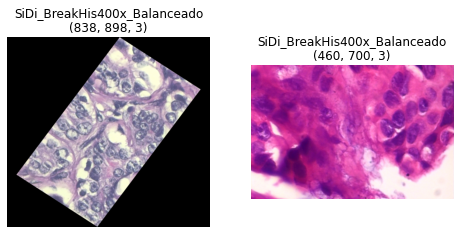

In [8]:
# view random image from training dataset
plt.figure(figsize=(8,6))

plt.subplot(1,2,1)
img1 = view_random_image('datasets/SiDi_BreakHis400x_Balanceado/train_set/benign/')

plt.subplot(1,2,2)
img2 = view_random_image('datasets/SiDi_BreakHis400x_Balanceado/train_set/malignant/')

## Pre-processamento dos dados 

In [9]:
IMG_SHAPE = (331, 331, 3)
IMG_SIZE = (331, 331)
BATCH_SIZE = 32
EPOCHS = 100

In [10]:
# Rescale
train_datagen = ImageDataGenerator(rescale=None)
validation_datagen = ImageDataGenerator(rescale=None)
test_datagen = ImageDataGenerator(rescale=None)

# # Load data in from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir, target_size=IMG_SIZE, 
                                               batch_size=32, class_mode='categorical')

validation_data = validation_datagen.flow_from_directory(val_dir, target_size=IMG_SIZE, 
                                                         batch_size=32,class_mode='categorical')

test_data = validation_datagen.flow_from_directory(test_dir, target_size=IMG_SIZE, 
                                                   batch_size=32, class_mode='categorical')



Found 2074 images belonging to 2 classes.
Found 360 images belonging to 2 classes.
Found 159 images belonging to 2 classes.


In [11]:
num_train = train_data.samples
num_validation = validation_data.samples
num_test = test_data.samples

In [12]:
print (validation_data.class_indices)

{'benign': 0, 'malignant': 1}


## Criando o modelo

Baseado em: https://keras.io/api/applications/nasnet/

## NasNetLarge

In [13]:
from tensorflow.keras import layers

def build_model(num_classes, input_image_size):
    inputs = layers.Input(shape=IMG_SHAPE)
    x = tf.cast(inputs, tf.float32)
    x = tf.keras.applications.nasnet.preprocess_input(x)

    model = tf.keras.applications.NASNetLarge(
        input_shape=None,
        include_top=False,
        weights="imagenet",
        input_tensor=x,
        pooling=None,
        classes=num_classes,
    )

    # Freeze the pretrained weights
    model.trainable = False

    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    #Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="NASNetLarge")
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    #print(model.summary())
    return model

In [14]:
num_classes = 2
input_img_size = 331

In [15]:
# turn on mixed precision training
mixed_precision.set_global_policy('mixed_float16') # set global data policy to mixed precision

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1650, compute capability 7.5


##  Treino e Avaliação do Modelo

In [16]:
def fitting_model(model):
    callbacks = [keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta=0.001, patience=7),
                 keras.callbacks.ModelCheckpoint(filepath='bestmodel_nasnet_large.hdf5', monitor='val_loss', save_best_only=True)] 
    
    with tf.device('/device:GPU:0'):
        history = model.fit(train_data, epochs=EPOCHS, steps_per_epoch=len(train_data), validation_data=validation_data,
                           validation_steps=len(validation_data), callbacks=callbacks)
    return history

In [17]:
%%time
## NASNet
model = build_model(num_classes, input_img_size)
history = fitting_model(model)

Epoch 1/100
65/65 [==============================] - 999s 15s/step - loss: 0.3628 - accuracy: 0.8467 - val_loss: 0.6362 - val_accuracy: 0.6750
Epoch 2/100
65/65 [==============================] - 483s 7s/step - loss: 0.2155 - accuracy: 0.9084 - val_loss: 0.5740 - val_accuracy: 0.7278
Epoch 3/100
65/65 [==============================] - 464s 7s/step - loss: 0.1564 - accuracy: 0.9373 - val_loss: 0.8573 - val_accuracy: 0.6833
Epoch 4/100
65/65 [==============================] - 920s 14s/step - loss: 0.1143 - accuracy: 0.9542 - val_loss: 0.3943 - val_accuracy: 0.8417
Epoch 5/100
65/65 [==============================] - 952s 15s/step - loss: 0.0721 - accuracy: 0.9716 - val_loss: 0.8776 - val_accuracy: 0.7500
Epoch 6/100
65/65 [==============================] - 958s 15s/step - loss: 0.0564 - accuracy: 0.9778 - val_loss: 0.7427 - val_accuracy: 0.7861
Epoch 7/100
65/65 [==============================] - 971s 15s/step - loss: 0.0577 - accuracy: 0.9793 - val_loss: 0.4813 - val_accuracy: 0.8194
E

In [20]:
# Plotting the validation and training curves separately

def plot_loss_curves(history, network):
    """
    Returns separeted loss curves for training and validation metrics.
    """
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    epochs = range(len(history.history['loss'])) # how many epochs did we run for?
    
    plt.figure(figsize=(14,4))
    
    # plot loss
    plt.subplot(1,2,1)
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='validation_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    
    #plot accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, accuracy, label='accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    
    plt.suptitle(network, fontsize=14)

5/5 [==============================] - 62s 12s/step - loss: 0.5801 - accuracy: 0.8365


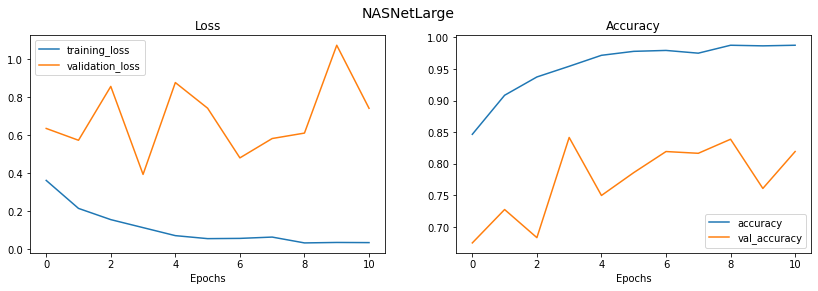

In [21]:
loss, acc = model.evaluate(test_data)
plot_loss_curves(history, "NASNetLarge")

### Salvar o modelo

In [22]:
model.save('models_saved/NasNetLarge')

INFO:tensorflow:Assets written to: models_saved/NasNetLarge\assets


INFO:tensorflow:Assets written to: models_saved/NasNetLarge\assets


## Implementando o Grad-CAM no Modelo

In [13]:
# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [14]:
nasnet = keras.models.load_model('models_saved/NasNetLarge')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1650, compute capability 7.5


In [21]:
#nasnet.summary()

In [22]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    
    return array

In [23]:
preprocess_input = tf.keras.applications.nasnet.preprocess_input
decode_predictions = tf.keras.applications.nasnet.decode_predictions

last_conv_layer_name = list(filter(lambda x: isinstance(x,keras.layers.Conv2D), 
                                                          nasnet.layers))[-1].name
print(last_conv_layer_name)

normal_conv_1_18


In [24]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    #grad_model.summary()

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, predictions = grad_model(img_array)
        predictions = tf.squeeze(predictions)
        if pred_index is None:
            pred_index = tf.argmax(predictions)
        class_channel = predictions[pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

## Select sample

In [25]:
def generate_heatmap(img_path):
    img_array = get_img_array(img_path, size=IMG_SIZE)

    # Print what the top predicted class is
    preds = nasnet.predict(img_array, verbose=0)
    top_pred_index = np.argmax(preds[0])

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(img_array, nasnet, last_conv_layer_name)
    heat_test = heatmap.copy()

    # Display heatmap
#     print(heatmap)
#     plt.matshow(heatmap)
#     plt.show()
    
    return heatmap, class_names[top_pred_index], preds[0][top_pred_index] #100 * np.max(score) 


In [44]:
plt.figure(figsize=(16,12))

def save_and_display_gradcam(img_path, heatmap, alpha=1, pred=None):

    # Load the original image
    img = tf.keras.utils.load_img(img_path)
    img = tf.keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    if pred == 'malignant':
        jet = cm.get_cmap("gray")
    else:
        jet = cm.get_cmap("Greens")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
         
    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap) #keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = np.array(jet_heatmap) # keras.preprocessing.image.img_to_array(jet_heatmap)

    
    # only for generating images
    # Superimpose the heatmap on original image
    superimposed_img = (jet_heatmap * alpha) + img
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)

        # Otsu's thresholding
    jet_heatmap = cv.cvtColor(jet_heatmap, cv.COLOR_BGR2GRAY)
    _, thresh = cv.threshold(jet_heatmap,0,255, cv.THRESH_BINARY + cv.THRESH_OTSU)

    plt.imshow(superimposed_img)
    return thresh

<Figure size 1152x864 with 0 Axes>

## Gerando o Dataset

In [27]:
def loading_json(filen='datasets/groundTruth/'):
    tumor_cells = {}
    annot_points = {}
    
    for root, dirs, items in os.walk(filen):
        for i, item in enumerate(items):
            # Opening JSON file
            f = open(filen+item)
            # returns JSON object as 
            # a dictionary
            data = json.load(f)
            
            # adding values to dictionary
            tumor_cells[item.split('.')[0]] = len(data['tumor'])
            
            # creating list to get the annotations coordinates
            x_y = []
            for j, points in enumerate(data['tumor']):
                # list to get the coordinates of one annotation
                values_i_j = []
                
                # the values are multiplied by the image resolution
                values_i_j.append(int(points['x']*1360))
                values_i_j.append(int(points['y']*1024))
                
                # adding the coordinates to the list of one case
                x_y.append(values_i_j)
            
            # adding corresponding annotations to the respective case
            annot_points[item.split('.')[0]] = x_y

            # Closing file
            f.close()
            
    return tumor_cells, annot_points

In [28]:
def getting_probs(filen='datasets/brecahad_test_set/malignant/'):
    
    # loading test images
    probs = []
    classes = []
    masks = []
    for root, dirs, items in os.walk(filen):
        for item in items:
            heatmap, class_, prob = generate_heatmap(filen+item)
            mask = save_and_display_gradcam(filen+item, heatmap, pred=class_)
            probs.append(round(prob*100,2))
            classes.append(class_)
            masks.append(mask)
            

    return classes, masks, probs

In [29]:
def checking_points(annot_points, lst_heatmaps):
    
    # list to check the correct values
    correct_values = []
    i = 0
    
    for k, v in annot_points.items():
        got_it_right = 0
        mask_matrix = lst_heatmaps[i]
        
        for a, b in enumerate(v):
            if mask_matrix[b[1]][b[0]] > 0:
                got_it_right += 1
        # adding the correct correspondences to the list      
        correct_values.append(got_it_right)
        i += 1
        
    return correct_values

In [30]:
def generating_dataset():
    
    tumor_cells, annot_points = loading_json()
    lst_classes, lst_heatmaps, lst_probs = getting_probs()
    lst_tumors = checking_points(annot_points, lst_heatmaps)
    tumor_region = []
    accuracy = []
    
    # tumors found
    tumor_cells_values = list(tumor_cells.values())
    
    for i, qtd in enumerate(lst_tumors):
        if lst_classes[i] == 'benign':
            tumor_region.append(0)
            accuracy.append(0)
            
        else:
            tumor_region.append(round((qtd/tumor_cells_values[i])*100, 2))
            
    
    dataframe = pd.DataFrame(data=[tumor_cells.keys(), tumor_cells.values(), lst_classes, lst_probs,
                                  lst_tumors, tumor_region],
                             index=['Case', 'Total Tumor Cells', 'Pred. Type', 'Probability (%)',
                                     'Tumors Found' ,'Interpret. Region Accuracy (%)']).transpose()
    
    return dataframe

## Dataset

In [31]:
df = generating_dataset()

In [32]:
df.head(15)

,Case,Total Tumor Cells,Pred. Type,Probability (%),Tumors Found,Interpret. Region Accuracy (%)
0,Case_1-01,140,malignant,98.83,0,0.0
1,Case_1-02,153,malignant,100.0,0,0.0
2,Case_1-03,135,malignant,100.0,3,2.22
3,Case_1-04,103,malignant,100.0,0,0.0
4,Case_1-05,126,malignant,100.0,0,0.0
5,Case_1-06,176,malignant,100.0,0,0.0
6,Case_1-07,196,malignant,100.0,0,0.0
7,Case_1-08,116,malignant,97.95,0,0.0
8,Case_10-01,162,malignant,96.58,13,8.02
9,Case_10-02,139,malignant,99.56,41,29.5


In [52]:
accuracy = 100*(len(df[(df['Pred. Type'] == 'malignant')].index)/len(df.index))
print("Acurácia de Classificação (%): ",round(accuracy,2))

Acurácia de Classificação (%):  83.65


## Métricas

In [53]:
# Interpretability

mean = df[df['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)'].mean()
stdd = df[df['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)'].std()
summ_total = df[df['Pred. Type'] == 'malignant']['Total Tumor Cells'].sum()
summ_ind = df[df['Pred. Type'] == 'malignant']['Tumors Found'].sum()
median = df[df['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)'].median()
max_v = df[df['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)'].max()
min_v = df[df['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)'].min()
itp_model = round(mean, 2)
std_deviation = round(stdd, 2)
median_model = round(median, 2)

print(f'Model Average Interpretability: {itp_model} +/- {std_deviation}. With Median: {median_model}')
print(f'\nMin.: {min_v} | Max.: {max_v}')

Model Average Interpretability: 8.62 +/- 12.32. With Median: 1.2

Min.: 0.0 | Max.: 63.87


Text(0.5, 1.0, 'Histogram of Region Accuracy')

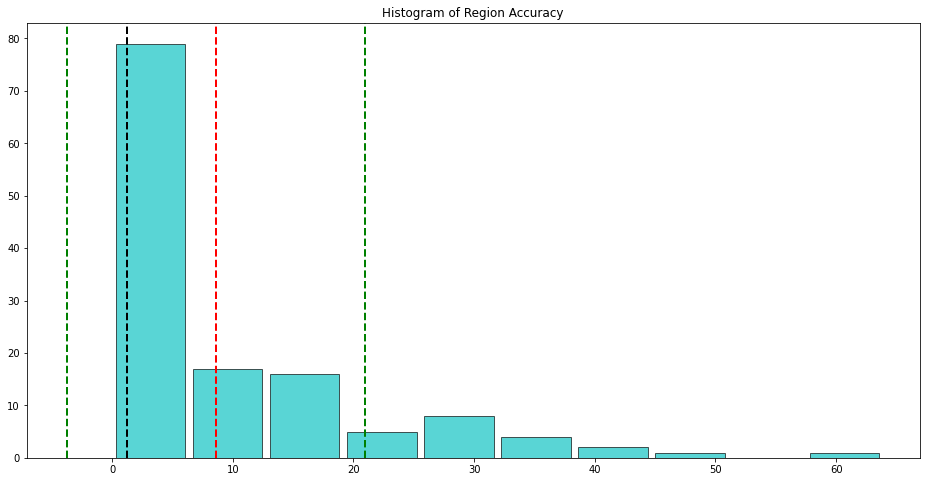

In [35]:
plt.figure(figsize=(16,8))
values = df[df['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)']
plt.hist(x=values, bins=10, color='c', edgecolor='k', alpha=0.65, rwidth=0.9)
plt.axvline(values.median(), color='k', linestyle='dashed', linewidth=2)
plt.axvline(values.mean(), color='red', linestyle='dashed', linewidth=2)
plt.axvline(values.mean() + values.std(), color='green', linestyle='dashed', linewidth=2)
plt.axvline(values.mean() - values.std(), color='green', linestyle='dashed', linewidth=2)
plt.title('Histogram of Region Accuracy')

In [36]:
df[df['Interpret. Region Accuracy (%)'] == df['Interpret. Region Accuracy (%)'].max()]

,Case,Total Tumor Cells,Pred. Type,Probability (%),Tumors Found,Interpret. Region Accuracy (%)
140,Case_7-05,119,malignant,99.95,76,63.87


In [111]:
np.percentile(values, 98)

97.04159999999999

<hr> 

# Visualizando as imagens geradas

In [55]:
case='Case_11-09'

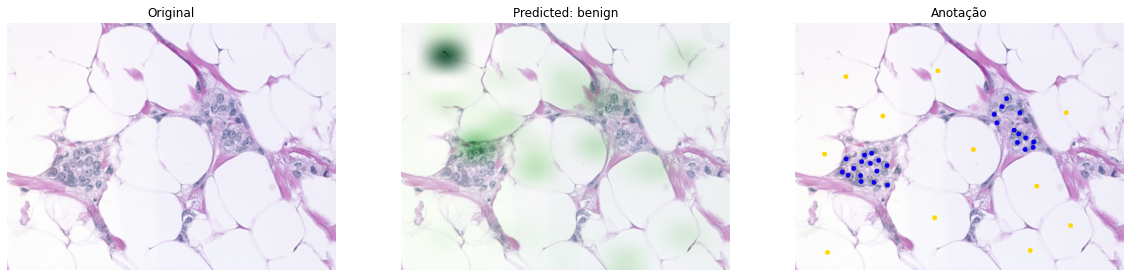

In [56]:
IMG = 'datasets/brecahad_test_set/malignant/'+case+'.png'
PATH1 = 'datasets/groundTruth_display/'+case+'.png'

img = tf.keras.utils.load_img(PATH1)
img_orig = tf.keras.utils.load_img(IMG)
heatmap1, class_1, probs1 = generate_heatmap(IMG)

plt.figure(figsize=(20,12))
plt.subplot(1,3,1)
plt.title('Original')
plt.axis(False)
plt.imshow(img_orig)
plt.subplot(1,3,2)
plt.title(f'Predicted: {class_1}')
plt.axis(False)
save_and_display_gradcam(img_path=IMG, heatmap=heatmap1, pred=class_1)
plt.subplot(1,3,3)
plt.title('Anotação')
plt.axis(False)
plt.imshow(img)

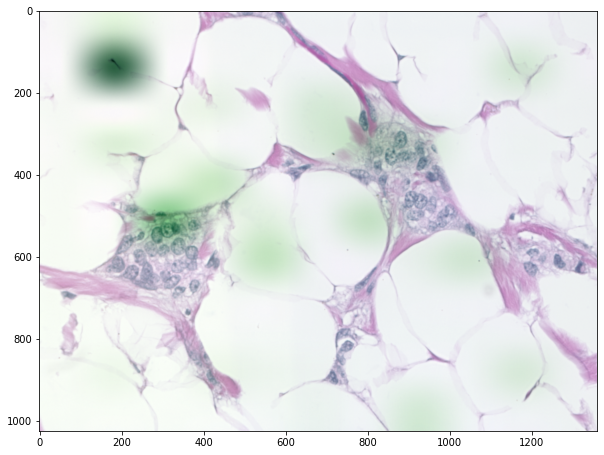

In [57]:
plt.figure(figsize=(10,10))
result = save_and_display_gradcam(img_path=IMG, heatmap=heatmap1, pred=class_1);

(1024, 1360)


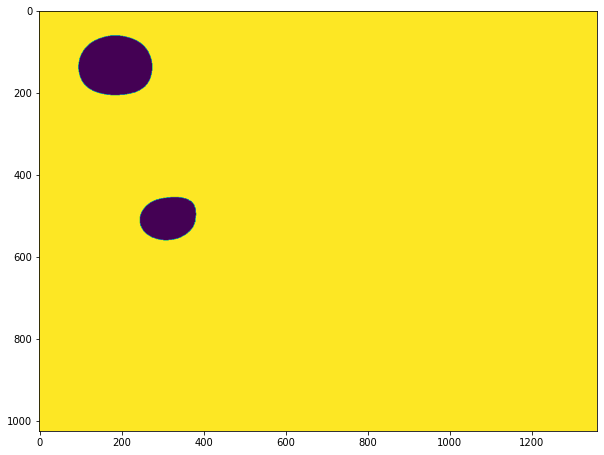

In [58]:
plt.figure(figsize=(10,10))
print(result.shape)

plt.imshow(result)

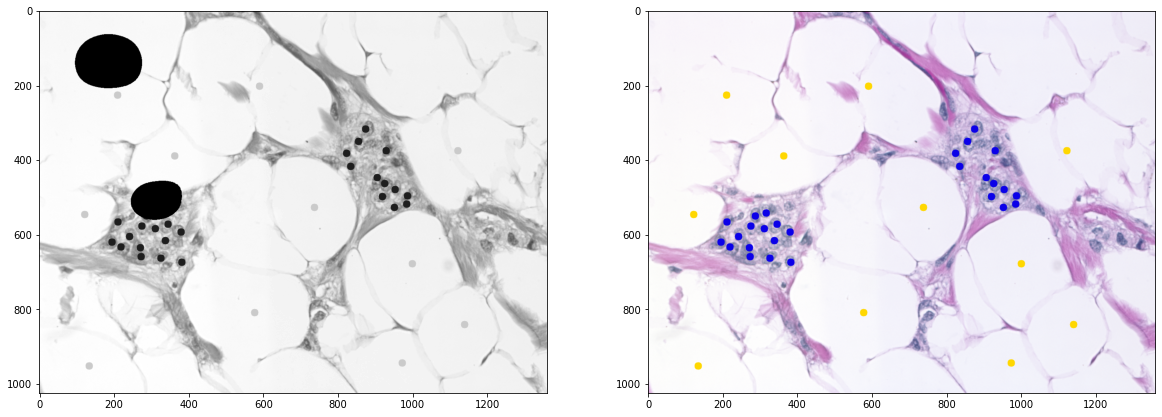

In [59]:
# inverting result mask
plt.figure(figsize=(20,20))
data1 = cv.imread(PATH1)
data1 = cv.cvtColor(data1, cv.COLOR_BGR2RGB)
final = cv.bitwise_and(data1, data1, mask = result)
final = cv.cvtColor(final, cv.COLOR_RGB2GRAY)
plt.subplot(1,2,1)
plt.imshow(final, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(data1)

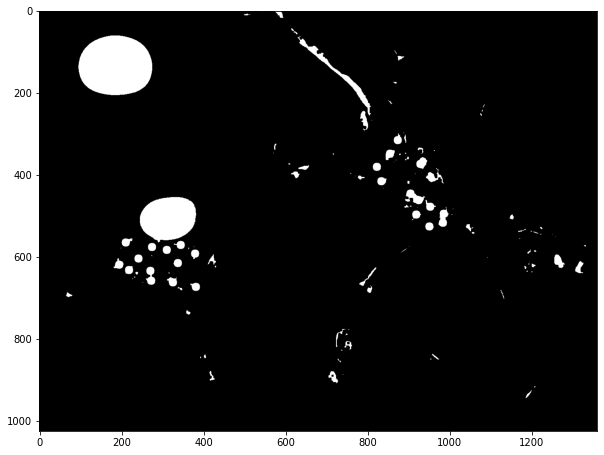

In [60]:
plt.figure(figsize=(10,10))

kernel = np.ones((5,5),np.uint8)
mask2 = cv.threshold(final,0,255,cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1]
mask2 = cv.morphologyEx(mask2, cv.MORPH_CLOSE, kernel)
mask2 = np.uint8(mask2)
plt.imshow(mask2, cmap='gray')

(1, 17, 3)


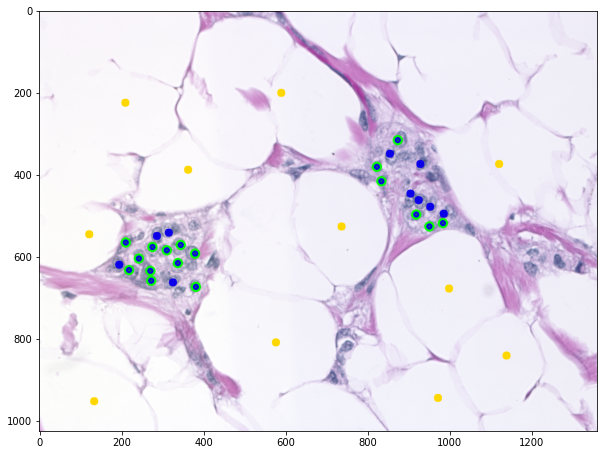

In [61]:
plt.figure(figsize=(10,10))

data2 = data1.copy()

##########
p_edges = cv.Canny(mask2, 0, 255)

##########
rows = p_edges.shape[0]
circles = cv.HoughCircles(mask2, cv.HOUGH_GRADIENT, dp=1.1, minDist=1, param1=1000, param2=15,
                          minRadius=2, maxRadius=11)
print(circles.shape)

if circles is not None:
    # mudando o tipo de dado para int
    circles = np.uint16(np.around(circles))
    for circ in circles[0, :]:
        center = (circ[0], circ[1])

        # centro do círculo
        cv.circle(data2, center, 1, (0, 100, 100), 3)

        # círculo externo
        radius = circ[2]
        cv.circle(data2, center, radius, (0, 255, 0), 4)

plt.imshow(data2)